In [43]:
import scipy
import scipy.sparse
import cPickle
import logging
import implicit
reload(implicit)
import implicit.approximate_als
reload(implicit.approximate_als)
import implicit.bpr
reload(implicit.bpr)
import sklearn
import numpy as np
import itertools
import random
import pandas as pd
import time
import lightfm
import tqdm
import seaborn as sns
%matplotlib inline
import util as C
reload(C)
import functools
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data

In [2]:
logging.basicConfig(level = logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [3]:
channel_helper = C.ChannelHelper()
user_helper = C.UserHelper(channel_helper)

In [4]:
channel_helper.load_index_data()
channel_helper.load_meta_data()

In [5]:
channel_cid2idx, channel_idx2cid = channel_helper.channel_cid2idx, channel_helper.channel_idx2cid
channel_data, channel_pid_data = channel_helper.channel_data, channel_helper.channel_pid_data

In [6]:
%%time
train_mat_csr = C.load_mat(C.EVST_TRAIN_USER_ITEM_MAT_PATH)
test_mat_csr = C.load_mat(C.EVST_TEST_USER_ITEM_MAT_PATH)
train_mat = train_mat_csr.tocoo()
test_mat = test_mat_csr.tocoo()

CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 37 ms


In [7]:
train_mat2 = implicit.nearest_neighbours.bm25_weight(train_mat, K1 = 2.0, B = 0.8)
#train_mat2 = implicit.nearest_neighbours.tfidf_weight(train_mat)
train_mat_csr2 = train_mat2.tocsr()

In [20]:
train_mat_csr.shape, test_mat_csr.shape

((200000, 137344), (200000, 137344))

In [9]:
train_mat_csr.nnz, train_mat_csr2.nnz, test_mat_csr.nnz

(1306380, 1306380, 197456)

In [10]:
train_users_idx = np.arange(train_mat.shape[0])
test_users_idx = np.array(list(set(test_mat.row)))
test_users_idx.sort()

In [11]:
np.random.seed(42)
n_users = 2000
np.random.shuffle(test_users_idx)
test_user_ids = test_users_idx[:n_users]
np.random.shuffle(train_users_idx)
train_user_ids = train_users_idx[:n_users]

In [12]:
lfm_item_ids = np.arange(train_mat.shape[1])

In [13]:
test_meta_df = pd.read_csv(C.EVST_TEST_USER_ITEM_META_PATH, index_col=0)

In [14]:
test_meta_df.head(3)

,origin_idx,uid,subs
119737,1738927,8d0ad848e58d47718bc9048fe55e9941,6
72272,1835513,fb3c8041026043918bacedda05361106,7
158154,1790575,be64359ae3204dc1a550bf285f3896b0,10


In [21]:
test_meta_df.shape

(50000, 3)

# Evaluation

In [56]:
def compute_pred(model, user_id, N = 10, test = False, recalculate_user=False):
    if model.__module__.startswith('implicit'):
        if test:
            pred = model.recommend(user_id, user_items = train_mat_csr2, N = N)
            return pred
        else:
            user = model._user_factor(user_id, user_items = train_mat_csr2, 
                                      recalculate_user = recalculate_user)
            scores = model.item_factors.dot(user)
    else:
        scores = model.predict(user_ids = user_id, item_ids = lfm_item_ids, num_threads = 8)
    scores = -scores
    pred_idxs = np.argpartition(scores, N)[:N]
    pred = [(x, -scores[x]) for x in pred_idxs]
    pred.sort(key = lambda x: -x[1])
    return pred

    
def eval_user_recomm(model, user_id, N = 10, verbose = True, test = True):
    if test:
        truth_idxs = test_mat_csr[user_id].indices
    else:   
        truth_idxs = train_mat_csr[user_id].indices
    base_idxs = train_mat_csr2[user_id].indices
    pred = compute_pred(model, user_id, N = N, test = test)
    pred_idxs = [x[0] for x in pred]
    intersect = len(set(pred_idxs) & set(truth_idxs))
    a = intersect
    b = len(pred_idxs)
    c = len(truth_idxs)
    
    if verbose:
        print('base ...')
        base_pids = [channel_idx2cid[x] for x in base_idxs]
        for pid in base_pids:
            print('- {} {}'.format(pid, channel_pid_data[pid]['title']))

        print('pred ...')
        pred_pids = [channel_idx2cid[x] for x in pred_idxs]
        for idx, pid in enumerate(pred_pids):
            print('- {} {} {} {}'.format(pid, channel_pid_data[pid]['title'], pred_idxs[idx], pred[idx][1]))

        print('truth ...')
        true_pids = [channel_idx2cid[x] for x in truth_idxs]
        for pid in true_pids:
            print('- {} {}'.format(pid, channel_pid_data[pid]['title']))
    return a, b, c

def eval_all_users(model, user_ids, N = 10,  test = True):
    A, B,C = 0, 0,0
    for user_id in user_ids:
        a, b, c = eval_user_recomm(model, user_id, N = N ,verbose = False, test = test)
        A += a
        B += b 
        C += c
    # precision, recall
    return round(A * 1.0 / B, 4), round(A * 1.0 / C, 4)

def item_recomm(model, cid, N=20,  verbose = True):
    idx = channel_cid2idx[cid]
    if model.__module__.startswith('implicit'):
        related = model.similar_items(idx, N=N)
        res = []
        for rid, score in related:
            pid= channel_idx2cid[rid]
            title = channel_pid_data[pid]['title']
            res.append((pid, title, score))
            
    else: # lightfm model.
        item_embeddings = model.item_embeddings
        scores = item_embeddings.dot(item_embeddings[idx])
        norm_scores = -scores / np.linalg.norm(item_embeddings, axis = -1)
        scores_idx = norm_scores.argpartition(N)
        scores_idx = scores_idx[:N]
        scores_idx_value = list(zip(scores_idx, [norm_scores[x] for x in scores_idx]))
        scores_idx_value = sorted(scores_idx_value, key = lambda x: x[1])
        res = []
        for idx, value in scores_idx_value:
            pid= channel_idx2cid[idx]
            title = channel_pid_data[pid]['title']
            res.append((pid, title, value))

    if verbose:
        for pid, title, score in res:
            print('pid={}, title={}, score={:.2f}'.format(pid, title, score))
    return res

In [66]:
class History:
    def __init__(self, model, test_user_ids, train_user_ids):
        self.model = model
        self.test_user_ids = test_user_ids
        self.train_user_ids = train_user_ids
        self.test_scores = []
        self.train_scores = []
        
    def add_test_score(self, score):
        self.test_scores.append(score)
        
    def add_train_score(self, score):
        self.train_scores.append(score)
    
    def eval_test_users(self):
        return eval_all_users(model = self.model,user_ids = self.test_user_ids, test = True)

    def eval_train_users(self):
        return eval_all_users(model = self.model,user_ids = self.train_user_ids, test = False)
        
        
def fit_callback(hist, iterations, elapsed, interval = 1):
    if iterations % interval != 0: return
    start = time.time()
    test_score = hist.eval_test_users()
    hist.add_test_score(test_score)
    train_score = hist.eval_train_users()
    hist.add_train_score(train_score)
    end = time.time()
    print('iteration #{}, elapsed = ({:.2f}, {:.2f}), train_score = {}, test_score = {}'.
          format(iterations, elapsed, end - start, train_score, test_score))


In [58]:
def plot_precision_history(history):
    plt.plot([x[0] for x in history.train_scores])
    plt.plot([x[0] for x in history.test_scores])
    plt.xlabel('# of iteratios')
    plt.ylabel('p@k')
    plt.legend(['train', 'test'])

def plot_recall_history(history):
    plt.plot([x[1] for x in history.train_scores])
    plt.plot([x[1] for x in history.test_scores])
    plt.xlabel('# of iteratios')
    plt.ylabel('r@k')
    plt.legend(['train', 'test'])

# Train ALS Model

In [32]:
np.random.seed(42)
als_model = implicit.als.AlternatingLeastSquares(
    factors= 100, 
    regularization = 0.01,
    iterations = 10)
    #calculate_training_loss = True)
als_history = History(als_model, test_user_ids, train_user_ids)
als_model.fit_callback = functools.partial(fit_callback, als_history)

In [33]:
%%time
als_model.fit(train_mat_csr2.T)

DEBUG:implicit:Converting input to CSR format
DEBUG:implicit:Converted input to CSR in 0.052s
DEBUG:implicit:Calculated transpose in 0.088s
DEBUG:implicit:initialize factors in 0.651781082153
DEBUG:implicit:finished iteration 0 in 4.309s


iteration #0, elapsed = (4.31, 13.47), train_score = (0.2685, 0.4385), test_score = (0.0576, 0.1452)


DEBUG:implicit:finished iteration 1 in 4.203s


iteration #1, elapsed = (4.20, 13.43), train_score = (0.3423, 0.559), test_score = (0.0963, 0.2426)


DEBUG:implicit:finished iteration 2 in 4.427s


iteration #2, elapsed = (4.43, 13.73), train_score = (0.3475, 0.5675), test_score = (0.1112, 0.2801)


DEBUG:implicit:finished iteration 3 in 4.205s


iteration #3, elapsed = (4.20, 13.70), train_score = (0.3449, 0.5633), test_score = (0.1129, 0.2843)


DEBUG:implicit:finished iteration 4 in 4.322s


iteration #4, elapsed = (4.32, 13.95), train_score = (0.3424, 0.5593), test_score = (0.1123, 0.2828)


DEBUG:implicit:finished iteration 5 in 4.322s


iteration #5, elapsed = (4.32, 14.22), train_score = (0.3399, 0.5551), test_score = (0.1126, 0.2837)


DEBUG:implicit:finished iteration 6 in 4.287s


iteration #6, elapsed = (4.29, 13.95), train_score = (0.3382, 0.5523), test_score = (0.1124, 0.2833)


DEBUG:implicit:finished iteration 7 in 4.200s


iteration #7, elapsed = (4.20, 13.98), train_score = (0.337, 0.5504), test_score = (0.1123, 0.2828)


DEBUG:implicit:finished iteration 8 in 4.244s


iteration #8, elapsed = (4.24, 13.93), train_score = (0.3362, 0.5491), test_score = (0.1116, 0.2813)


DEBUG:implicit:finished iteration 9 in 4.326s


iteration #9, elapsed = (4.33, 13.90), train_score = (0.3352, 0.5474), test_score = (0.1115, 0.2809)
CPU times: user 21min 15s, sys: 26min 44s, total: 47min 59s
Wall time: 3min 1s


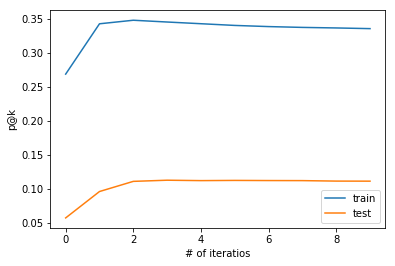

In [34]:
plot_precision_history(als_history)

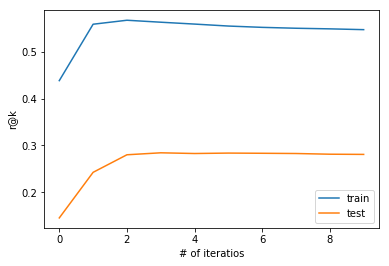

In [35]:
plot_recall_history(als_history)

# ALS Validation

In [39]:
n = np.random.randint(0, len(test_users_idx))
user_id = test_users_idx[n]
print('uid = {}'.format(test_meta_df.loc[user_id]['uid']))
eval_user_recomm(als_model, user_id)

uid = b5649401363740f9b84f66bb6ae45642
base ...
- 1061905 Under Center Podcast
- 64401 Chicago Bears Review
- 364800 NFL Live
- 416160 The Brain Warrior's Way Podcast
pred ...
- 1100514 The Herd with Colin Cowherd 35068 0.136646807194
- 1049522 Around the NFL 4322 0.136386871338
- 364799 Fantasy Focus Football 63389 0.116580404341
- 364788 First Take 63378 0.116289585829
- 5524 Fantasy Footballers - Fantasy Football Podcast 4206 0.112239122391
- 375949 Skip and Shannon: Undisputed 12937 0.112237945199
- 364784 PTI 63374 0.100869633257
- 971762 The Bill Simmons Podcast 104479 0.0842054784298
- 1060640 Pardon My Take 9135 0.075991332531
- 364791 The Dan Le Batard Show with Stugotz 63381 0.0728379487991
truth ...
- 1049761 NFL: Good Morning Football
- 1049522 Around the NFL
- 1073314 Chicago Bears Podcasts
- 42269 The NFL Podcast Network


(1, 10, 4)

In [51]:
ref_pids = [486852, 1241617, 285553, 1215926]
_= item_recomm(als_model, 486852, N = 50)

pid=486852, title=Deep Learning: Zero to One, score=1.00
pid=1106913, title=Brain Channel (Audio), score=0.98
pid=1136684, title=JuicyPeach Audio Erotica Podcast, score=0.97
pid=2348, title=Learning Machines 101, score=0.97
pid=357912, title=Internet of X: Innovation | Leadership | IoT | M2M, score=0.97
pid=530326, title=Artificial Intelligence News, score=0.97
pid=1135450, title=Self-Driving Cars: Dr. Lance Eliot "Podcast Series", score=0.97
pid=524005, title=R Weekly, score=0.97
pid=26120, title=Linear Digressions, score=0.97
pid=1516, title=O'Reilly Data Show - O'Reilly Media Podcast, score=0.97
pid=368100, title=Simplifying Analytics, score=0.97
pid=6849, title=Partially Derivative, score=0.96
pid=402010, title=This Week in Machine Learning & Artificial Intelligence (AI) Podcast, score=0.96
pid=538016, title=Machine Learning – Software Engineering Daily, score=0.96
pid=435748, title=Business Statistics - Undergraduate, score=0.96
pid=68152, title=Secrets of Selling to Physicians, s

# LFM Model

In [68]:
lfm_model = C.MyLightFM(no_components=100, loss = 'warp', learning_rate=0.02, random_state = 42)
lfm_history = History(lfm_model, test_user_ids[:200], train_user_ids[:200])
lfm_model.fit_callback = functools.partial(fit_callback, lfm_history, interval = 10)

In [73]:
%%time
lfm_model.fit_partial(train_mat2, epochs = 100, num_threads = 8, sample_weight=train_mat2)

iteration #100, elapsed = (1.30, 4.78), train_score = (0.2075, 0.3247), test_score = (0.1045, 0.2652)
Epoch 100 in 1.30s
Epoch 101 in 1.35s
Epoch 102 in 1.29s
Epoch 103 in 1.30s
Epoch 104 in 1.30s
Epoch 105 in 1.29s
Epoch 106 in 1.29s
Epoch 107 in 1.29s
Epoch 108 in 1.29s
Epoch 109 in 1.29s
iteration #110, elapsed = (1.29, 4.68), train_score = (0.211, 0.3302), test_score = (0.103, 0.2614)
Epoch 110 in 1.29s
Epoch 111 in 1.29s
Epoch 112 in 1.29s
Epoch 113 in 1.29s
Epoch 114 in 1.29s
Epoch 115 in 1.29s
Epoch 116 in 1.40s
Epoch 117 in 1.29s
Epoch 118 in 1.29s
Epoch 119 in 1.32s
iteration #120, elapsed = (1.29, 4.51), train_score = (0.215, 0.3365), test_score = (0.104, 0.264)
Epoch 120 in 1.29s
Epoch 121 in 1.40s
Epoch 122 in 1.50s
Epoch 123 in 1.37s
Epoch 124 in 1.29s
Epoch 125 in 1.29s
Epoch 126 in 1.29s
Epoch 127 in 1.29s
Epoch 128 in 1.29s
Epoch 129 in 1.29s
iteration #130, elapsed = (1.29, 4.42), train_score = (0.216, 0.338), test_score = (0.104, 0.264)
Epoch 130 in 1.29s
Epoch 131 in

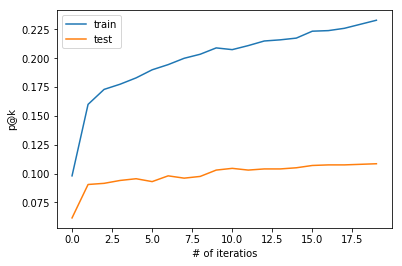

In [74]:
plot_precision_history(lfm_history)

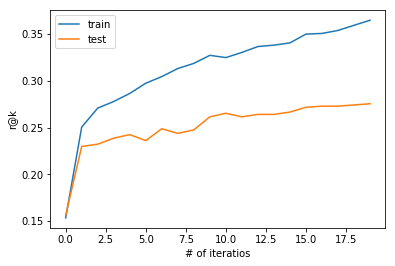

In [75]:
plot_recall_history(lfm_history)

In [76]:
%%time
eval_all_users(lfm_model, test_user_ids, N = 10)

CPU times: user 2min 40s, sys: 0 ns, total: 2min 40s
Wall time: 24.3 s


(0.107, 0.2694)

# LFM Validation

In [49]:
n = np.random.randint(0, len(test_users_idx))
user_id = test_users_idx[n]
print('uid = {}'.format(test_meta_df.loc[user_id]['uid']))
eval_user_recomm(lfm_model, user_id)

uid = 021f7c72c8044ade89ce0ee77b1630a7
base ...
- 444892 Pod Save America
- 1244953 American Innovations
- 1260172 The Wonderland Murders by Hollywood & Crime
pred ...
- 1260172 The Wonderland Murders by Hollywood & Crime 116131 4.966152668
- 1608 The Joe Rogan Experience 1265 4.65477800369
- 423933 In the Dark 93552 4.28064012527
- 1268029 Revisionist History 119959 4.20242595673
- 593291 30 For 30 Podcasts 134112 4.09824228287
- 1244953 American Innovations 109501 4.04016399384
- 1189174 My Favorite Murder with Karen Kilgariff and Georgia Hardstark 83083 3.99197769165
- 1208791 15 Minutes to Freedom:  A Warrior’s Daily Focus on Journals and Meditations 92724 3.95641732216
- 463650 The Daily 92862 3.76346993446
- 1092111 Brown Chicken Brown Cow Podcast 136926 3.76191091537
truth ...
- 1608 The Joe Rogan Experience
- 1814 This American Life
- 1189174 My Favorite Murder with Karen Kilgariff and Georgia Hardstark
- 1268029 Revisionist History


(3, 10, 4)

In [65]:
ref_pids = [486852, 1241617, 285553, 1215926]
_ = item_recomm(lfm_model,486852)

pid=486852, title=Deep Learning: Zero to One, score=-1.90
pid=1106913, title=Brain Channel (Audio), score=-1.68
pid=430952, title=Adversarial Learning, score=-1.57
pid=1086441, title=Crypto Traders Pro, score=-1.52
pid=524085, title=Artificially Intelligent, score=-1.51
pid=435748, title=Business Statistics - Undergraduate, score=-1.50
pid=346332, title=Linear Digressions, score=-1.50
pid=402010, title=This Week in Machine Learning & Artificial Intelligence (AI) Podcast, score=-1.49
pid=650739, title=Talking Machines, score=-1.48
pid=43384, title=HHS Linear Algebra, score=-1.46
pid=578031, title=Data Driven, score=-1.46
pid=115063, title=Stats + Stories, score=-1.45
pid=650841, title=Machine Learning Guide, score=-1.44
pid=2348, title=Learning Machines 101, score=-1.44
pid=25629, title=Artificial Intelligence in Industry with Dan Faggella, score=-1.44
pid=1136684, title=JuicyPeach Audio Erotica Podcast, score=-1.44
pid=26120, title=Linear Digressions, score=-1.43
pid=1062110, title=Bri